# 数据预处理-2

- 班级:2017211314
- 学号:2017213508
- 学生:蒋雪枫

## 作业3

**一些额外的Trick:**
#比如想要产生新的一列来统计同一时间内所有地方的PM指数和
df['sumOfPM']=df['PM_US_POST']+df['PM_Nongzhanguan']+df['PM_Dongsi']+df['PM_Dongsihuan']
#比如想要按照某一列排序,升序
def top(df,n=5,colunm='PRES'):
    return df.sort_values(by=column)[-n:]
#apply函数是`pandas`里面所有函数中自由度最高的函数。该函数如下：
DataFrame.apply(func, axis=0, broadcast=False, raw=False...)
该函数最有用的是第一个参数，这个参数是函数，相当于C/C++的函数指针。

#这次预处理实验和上次预处理实验后,我明显感受到直接按列操作比遍历每一个csv中的cell效率高得多,减小了IO时间

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

df = pd.read_csv("BeijingPM20100101_20151231.csv",encoding='utf-8')
df.describe()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,25052.000000,20508.000000,24931.000000,50387.000000,52579.000000,52245.000000,52245.000000,52579.000000,52579.000000,52100.000000,52100.000000
mean,26292.500000,2012.499772,6.523962,15.726609,11.500000,2.491100,89.154439,92.560806,88.643737,95.904241,2.074554,54.602421,1016.465442,12.587040,23.261829,19.258683,19.519008
std,15179.837614,1.707485,3.448452,8.798896,6.922252,1.116988,87.239267,88.027434,88.041166,91.643772,14.222059,25.991338,10.295070,12.098527,49.281706,4381.035532,4381.036040
min,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,1.000000,-40.000000,2.000000,991.000000,-19.000000,0.450000,0.000000,0.000000
25%,13146.750000,2011.000000,4.000000,8.000000,5.750000,1.000000,24.000000,28.000000,24.000000,27.000000,-10.000000,31.000000,1008.000000,2.000000,1.790000,0.000000,0.000000
50%,26292.500000,2012.000000,7.000000,16.000000,11.500000,2.000000,64.000000,68.000000,62.000000,69.000000,2.000000,55.000000,1016.000000,14.000000,4.920000,0.000000,0.000000
75%,39438.250000,2014.000000,10.000000,23.000000,17.250000,3.000000,124.000000,127.000000,122.000000,132.000000,15.000000,78.000000,1025.000000,23.000000,21.020000,0.000000,0.000000
max,52584.000000,2015.000000,12.000000,31.000000,23.000000,4.000000,737.000000,672.000000,844.000000,994.000000,28.000000,100.000000,1046.000000,42.000000,585.600000,999990.000000,999990.000000


In [2]:
todo = ['HUMI', 'PRES', 'TEMP']
#进行线性插值
for each in todo:
    df[each]=df[each].interpolate(method="linear")
print("将dataframe其中一列抽出来是什么类型?{}".format(type(df['HUMI'])))
for each in todo:
    mean = df[each].mean()
    stdDoub = df[each].std()
    df[each]= df[each].apply(lambda x : mean + stdDoub*2 if x>mean + stdDoub * 2 
                                  else ( mean-2 * stdDoub if x < mean -  2 * stdDoub else x))


将dataframe其中一列抽出来是什么类型?<class 'pandas.core.series.Series'>


In [3]:
todo = ['PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan']
print("处理前")
#   PM:6,7,8,9 || HUMI PRES TEMP:11,12,13 || cbwd:14
print(df.iloc[30590:30600,6:9])
for each in todo:
    df[each] = df[each].apply(lambda x: 500 if x > 500 else x)
print("处理后")
print(df.iloc[30590:30600,6:9])

处理前
       PM_Dongsi  PM_Dongsihuan  PM_Nongzhanguan
30590      287.0          443.0            326.0
30591      495.0          508.0            512.0
30592      495.0          513.0            513.0
30593      485.0          513.0            501.0
30594      515.0          537.0            530.0
30595      507.0          505.0            508.0
30596      487.0          443.0            475.0
30597      345.0          351.0            357.0
30598       34.0           39.0             28.0
30599       30.0           40.0             24.0
处理后
       PM_Dongsi  PM_Dongsihuan  PM_Nongzhanguan
30590      287.0          443.0            326.0
30591      495.0          500.0            500.0
30592      495.0          500.0            500.0
30593      485.0          500.0            500.0
30594      500.0          500.0            500.0
30595      500.0          500.0            500.0
30596      487.0          443.0            475.0
30597      345.0          351.0            357.0
30598       

In [4]:
#下面第一种方式比较直观,但如果出现两个连续的cv,怎么处理?  
# Excel里面也告诉我们的确出现了
# for i in range(len(df['cbwd'])):
#     if df['cbwd'][i] == 'cv':
#         df.at[i:i,'cbwd'] =  df['cbwd'][i+1]
print("对CV处理前")
print(df.iloc[20:25,8:15])
print("对CV处理后")
#TODO:采用bfill替换方式
df['cbwd']=df['cbwd'].replace('cv',method='bfill')
print(df.iloc[20:25,8:15])

对CV处理前
    PM_Nongzhanguan  PM_US Post  DEWP  HUMI    PRES  TEMP cbwd
20              NaN         NaN -17.0  38.0  1017.0  -5.0   cv
21              NaN         NaN -17.0  38.0  1018.0  -5.0   NW
22              NaN         NaN -17.0  38.0  1018.0  -5.0   NW
23              NaN       129.0 -17.0  41.0  1020.0  -5.0   cv
24              NaN       148.0 -16.0  38.0  1020.0  -4.0   SE
对CV处理后
    PM_Nongzhanguan  PM_US Post  DEWP  HUMI    PRES  TEMP cbwd
20              NaN         NaN -17.0  38.0  1017.0  -5.0   NW
21              NaN         NaN -17.0  38.0  1018.0  -5.0   NW
22              NaN         NaN -17.0  38.0  1018.0  -5.0   NW
23              NaN       129.0 -17.0  41.0  1020.0  -5.0   SE
24              NaN       148.0 -16.0  38.0  1020.0  -4.0   SE


In [5]:
df.describe() 

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,25052.000000,20508.000000,24931.000000,50387.000000,52579.000000,52584.000000,52584.000000,52584.000000,52579.000000,52100.000000,52100.000000
mean,26292.500000,2012.499772,6.523962,15.726609,11.500000,2.491100,88.909788,92.373464,88.409570,95.904241,2.074554,54.851158,1016.517506,12.599689,23.261829,19.258683,19.519008
std,15179.837614,1.707485,3.448452,8.798896,6.922252,1.116988,85.898308,87.056715,86.760055,91.643772,14.222059,26.095084,10.224785,12.063515,49.281706,4381.035532,4381.036040
min,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,1.000000,-40.000000,2.660485,995.931255,-11.609537,0.450000,0.000000,0.000000
25%,13146.750000,2011.000000,4.000000,8.000000,5.750000,1.000000,24.000000,28.000000,24.000000,27.000000,-10.000000,32.000000,1008.000000,2.000000,1.790000,0.000000,0.000000
50%,26292.500000,2012.000000,7.000000,16.000000,11.500000,2.000000,64.000000,68.000000,62.000000,69.000000,2.000000,55.000000,1016.000000,14.000000,4.920000,0.000000,0.000000
75%,39438.250000,2014.000000,10.000000,23.000000,17.250000,3.000000,124.000000,127.000000,122.000000,132.000000,15.000000,78.000000,1025.000000,23.000000,21.020000,0.000000,0.000000
max,52584.000000,2015.000000,12.000000,31.000000,23.000000,4.000000,500.000000,500.000000,500.000000,994.000000,28.000000,100.000000,1037.147438,36.783754,585.600000,999990.000000,999990.000000


In [6]:
df.to_csv("result.csv")

####  比较前后的描述信息,可以较为明显地看出有关标准差采取的措施带来的改变

## 作业4

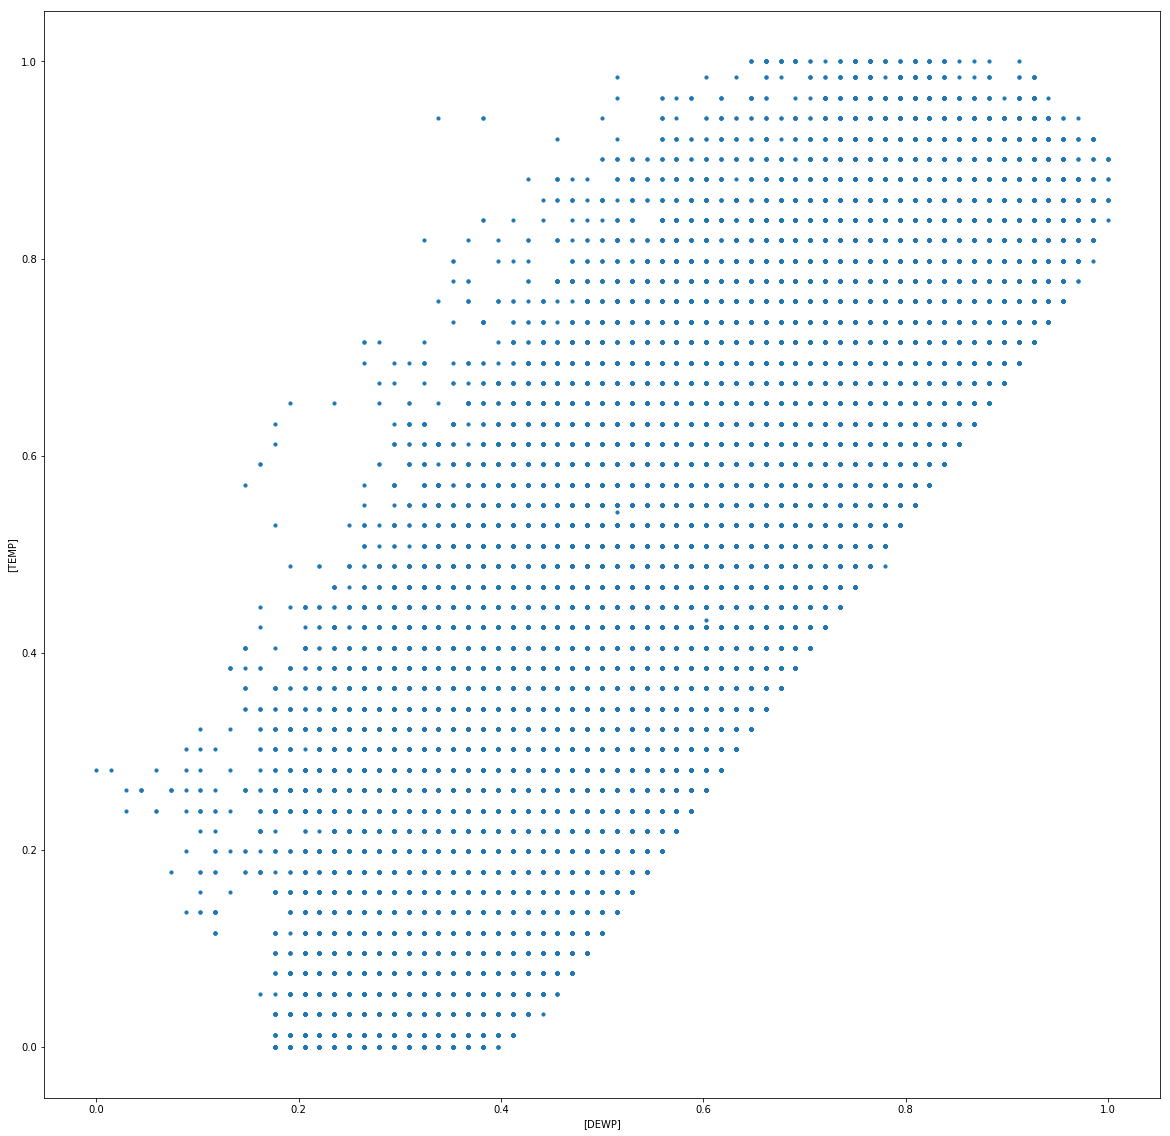

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['DEWP', 'TEMP']
df[features] = scaler.fit_transform(df[features])
df.head()
df.plot.scatter(x=['DEWP'],y=['TEMP'],s=10,figsize = (20,20))

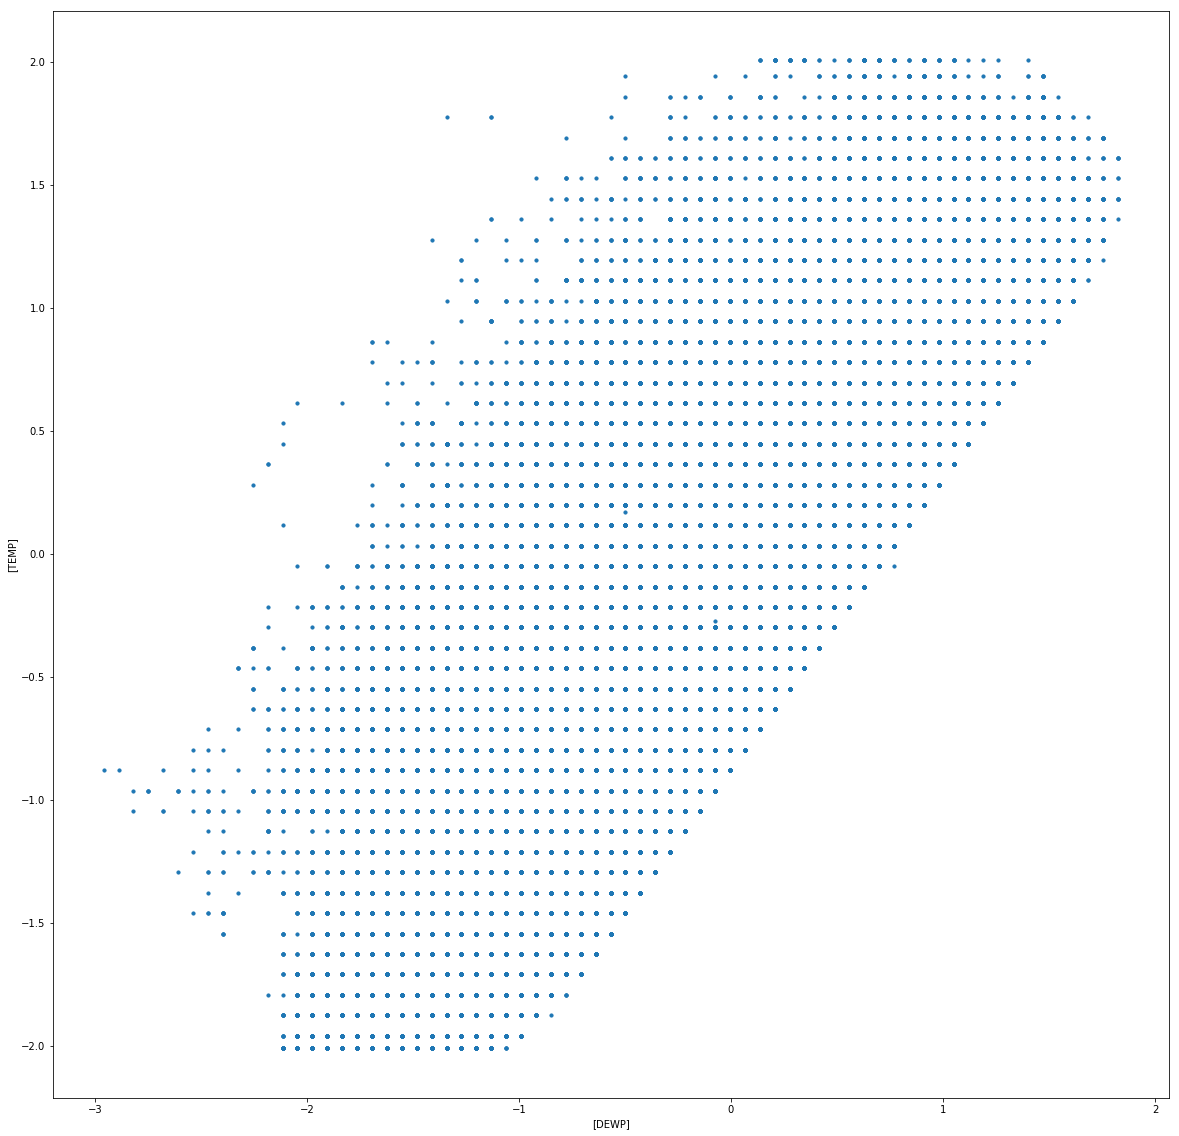

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features = ['DEWP', 'TEMP']
df[features] = ss.fit_transform(df[features])
df.head()
df.plot.scatter(x=['DEWP'],y=['TEMP'],s=10,figsize = (20,20))

In [9]:
sections = [0,50,100,150,200,300,1200] #划分为不同长度 的区间 
section_names=["green","yellow","orange","red","purple", "Brownish red"] #设置每个区间的标签
# df = df.fillna(df.mean())
result = pd.cut(df.PM_Dongsi,sections,labels=section_names) 
print(pd.value_counts(result))

green           10576
yellow           6268
orange           3578
red              1942
purple           1910
Brownish red      778
Name: PM_Dongsi, dtype: int64
